In [1]:
# Import Libraries
import cv2
import numpy as np
import pandas as pd
import os
import struct
import numpy.matlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('error', RuntimeWarning)

%matplotlib osx

# Headers for different tables
meta_data_header = ['FrameNumber', 'Time', 'Stage_x', 'Stage_y', 'Centroid_x', 'Centroid_y',
                    'Midpoint_x', 'Midpoint_y', 'Head_x', 'Head_y', 'Tail_x', 'Tail_y', 'MouthHook_x', 'MouthHook_y',
                    'LeftMHhook_x', 'LeftMHhook_y', 'RightMHhook_x', 'RightMHhook_y',
                    'LeftDorsalOrgan_x', 'LeftDorsalOrgan_y', 'RightDorsalOrgan_x', 'RightDorsalOrgan_y',
                    'CenterBolwigOrgan_x', 'CenterBolwigOrgan_y', 'LeftBolwigOrgan_x', 'LeftBolwigOrgan_y',
                    'RightBolwigOrgan_x', 'RightBolwigOrgan_y', 'V9_x', 'V9_y', 'V10_x', 'V10_y', 'V11_x', 'V11_y',
                    'V12_x', 'V12_y', 'V13_x', 'V13_y', 'V14_x', 'V14_y', 'V15_x', 'V15_y', 'V16_x', 'V16_y',
                    'MouthHook_votes', 'LeftMHhook_votes', 'RightMHhook_votes', 'LeftDorsalOrgan_votes',
                    'RightDorsalOrgan_votes', 'CenterBolwigOrgan_votes', 'LeftBolwigOrgan_votes', 'RightBolwigOrgan_votes',
                    'V9_votes', 'V10_votes', 'V11_votes', 'V12_votes', 'V13_votes', 'V14_votes', 'V15_votes',
                    'V16_votes', 'Num_Key_points']

coordinate_header = ['FrameNumber', 'MouthHook_x', 'MouthHook_y', 'LeftMHhook_x', 'LeftMHhook_y',
                     'RightMHhook_x', 'RightMHhook_y', 'LeftDorsalOrgan_x', 'LeftDorsalOrgan_y',
                     'RightDorsalOrgan_x', 'RightDorsalOrgan_y', 'CenterBolwigOrgan_x', 'CenterBolwigOrgan_y',
                     'LeftBolwigOrgan_x', 'LeftBolwigOrgan_y', 'RightBolwigOrgan_x', 'RightBolwigOrgan_y']

distance_header = ['MouthHook', 'LeftMHhook',
                   'RightMHhook', 'LeftDorsalOrgan', 'RightDorsalOrgan',
                   'CenterBolwigOrgan', 'LeftBolwigOrgan', 'RightBolwigOrgan']

def readSplineData(fileName, nFrames):
    fCount = 0;
    spline = {}
    with open(fileName, "rb") as f:
        while (True) and (fCount < nFrames-1):
            fCount += 1
            gap, frameNumber = struct.unpack('>ii', f.read(struct.calcsize('>ii')))

            nPointsToRead =  struct.unpack('>i', f.read(struct.calcsize('>i')))
            fmt = ">%dH" % (nPointsToRead)
            tempX = struct.unpack(fmt, f.read(struct.calcsize(fmt)))

            nPointsToRead =  struct.unpack('>i', f.read(struct.calcsize('>i')))
            fmt = ">%dH" % (nPointsToRead)
            tempY = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
            
            spline[frameNumber-1] = np.vstack((np.asarray(tempX).T, np.asarray(tempY).T))

    return spline

def readContourData(fileName, nFrames):    
    fCount = 0;
    contour = {}
    with open(fileName, "rb") as f:
        while (True) and (fCount < nFrames-1):
            fCount += 1
            frameNumber = struct.unpack('>i', f.read(struct.calcsize('>i')))

            nPointsToRead = struct.unpack('>i', f.read(struct.calcsize('>i')))            
            fmt = ">%dH" %(nPointsToRead)
            buff = f.read(struct.calcsize(fmt))
            tempX = struct.unpack(fmt, buff)
            
            nPointsToRead = struct.unpack('>i', f.read(struct.calcsize('>i')))
            fmt = ">%dH" %(nPointsToRead)
            buff = f.read(struct.calcsize(fmt))
            tempY = struct.unpack(fmt, buff)
            
            frameNumber = frameNumber[0]
            contour[frameNumber-1] = np.vstack((np.asarray(tempX).T, np.asarray(tempY).T))

    return contour

def computeHingePointNewTracker(xhead, yhead, xtail, ytail, xspine, yspine):
    if xhead-xtail == 0:
        m = (yhead-ytail)/(xhead+1-xtail);
    else:
        m = (yhead-ytail)/(xhead-xtail);
        
    n = (0.5)*((yhead+ytail)-np.multiply(m, (xhead+xtail)));
    sz = np.shape(xspine)[0]
    m2 = np.matlib.repmat(m, 1, sz);
    n2 = np.matlib.repmat(n, 1, sz);
    distances = np.abs(np.multiply(m, xspine) - yspine + n)/np.sqrt(np.square(m)+1);

    return np.argmax(distances)

In [2]:
## 20170317_7c0
# root = '../expts/trainingData_20170317_7c0/'

## 20180417_7c1_Hess_100
# root = '../expts/trainingData_20180417_7c1/'

## 20180417_7c1_Hess_50
# root = '../expts/20180417_7c1_Hess_50/'

## 20180417_7c1_Hess_25
# root = '../expts/20180417_7c1_Hess_25/'

## 20180417_7c1_Hess_100_Nbr_25
# root = '../expts/trainingData_20180417_7c1_Nbr_25/'

## 20180417_7c1_Hess_100_Nbr_25
# root = '../expts/trainingData_20180417_7c1_Nbr_25_ROI_128/'

## 20180417_7c1_Hess_100_ROI_128
# root = '../expts/trainingData_20180417_7c1_Hess_100_ROI_128/'

# 20180417_Individual
# root = '../expts/trainingData_20180417_Individual/'

# 20180417_7c1_Hess_100_BothDO
root = '../expts/trainingData_20180417_7c1_Hess_100_BothDO/'

# test_dir = root + 'dataCollectedOn_20180417_grp_1/Rawdata_20180417_084502_20180423_075225/'
# test_string = "Rawdata_20180417_084502" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_2/Rawdata_20180417_083618_20180420_104633/'
# test_string = "Rawdata_20180417_083618" ## Start frame in zero index

test_dir = root + 'dataCollectedOn_20180417_grp_3/Rawdata_20180417_082627_20180525_112343_A_133410/'
test_string = "Rawdata_20180417_082627" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_4/Rawdata_20180417_075246_20180420_092232_A_095851/'
# test_string = "Rawdata_20180417_075246" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_5/Rawdata_20180417_072307_20180523_100127_A_122116/'
# test_string = "Rawdata_20180417_072307" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_6/Rawdata_20180417_070739_20180522_151012/'
# test_string = "Rawdata_20180417_070739" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_7/Rawdata_20180417_065725_20180522_114055/'
# test_string = "Rawdata_20180417_065725" ## Start frame in zero index

# ## 20170317_7c1
# root = '../expts/trainingData_20170317_7c1/'

# ## 20180417_7c0
# root = '../expts/trainingData_20180417_7c0/'

# 20170318_5c0_test_170317
# root = '../expts/trainingData_20170318_5c0_test_170317/'

# test_dir = root + 'dataCollectedOn_20170317_grp_1/Rawdata_20170317_233847_20170321_034501/'
# test_string = "Rawdata_20170317_233847" ## Start frame in zero index

## Set path to the directory with video file
video_path = '../expts/videos_20180417/'
# video_path = '../expts/videos_20170317/'

video_file = os.path.join(video_path, test_string+".avi")
# video_file = os.path.join(video_path, test_string+".mp4")
test_string_2 = str.split(test_string, '_')[2]

crop_size = 512
spot_size = 18.22
font = cv2.FONT_HERSHEY_SIMPLEX

## Read tracker metadata and annotation
for fs in os.listdir(test_dir):
    if 'Metadata' in fs:
        meta_data = pd.read_csv(os.path.join(test_dir, fs), sep=',', header=0, names=meta_data_header)
    if 'Coordinates' in fs:
        coordinates = pd.read_csv(os.path.join(test_dir, fs), sep=',', names=coordinate_header)

numPoints = len(meta_data.index.values) + 1
for fs in os.listdir(test_dir):
    if 'Contour' in fs:
        contour = readContourData(os.path.join(test_dir, fs), numPoints)
    if 'SPLINE' in fs:        
        spline = readSplineData(os.path.join(test_dir, fs), numPoints)

if (meta_data.empty is False):

    ## OpenCV object for reading video files
    cap = cv2.VideoCapture(video_file)

    ## Total number of videos in the video file
    numberFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    ## Make the metadata frame umber start from 0 index
    meta_data.loc[:, 'FrameNumber'] = meta_data.loc[:, 'FrameNumber'] - 1
    meta_data.set_index('FrameNumber', inplace=True)
    margin = 100
    sub_int = 100
    for frame_num in contour:
        head_diff = contour[frame_num].T - np.reshape(meta_data.loc[frame_num, ['Head_x', 'Head_y']].values, (1, 2))
        head_dist = np.square(head_diff[:, 0] + head_diff[:, 1])
        head_index = np.argmin(head_dist)
        tail_diff = contour[frame_num].T - np.reshape(meta_data.loc[frame_num, ['Tail_x', 'Tail_y']].values, (1, 2))
        tail_dist = np.square(tail_diff[:, 0] + tail_diff[:, 1])
        tail_index = np.argmin(tail_dist)
        meta_data.loc[frame_num, 'Head_index'] = head_index
        meta_data.loc[frame_num, 'Tail_index'] = tail_index
        
        if head_index > tail_index:
            if head_index - margin > 0:
                head_index = head_index - margin

            if tail_index + margin < np.shape(contour[frame_num].T)[0]:
                tail_index = tail_index + margin
                
            curve_1 = contour[frame_num].T[tail_index:head_index, :]
            curve_2 = contour[frame_num].T[head_index+1:, :]
        else:
            if tail_index - margin > 0:
                tail_index = tail_index - margin

            if head_index + margin < np.shape(contour[frame_num].T)[0]:
                head_index = head_index + margin
                
            curve_1 = contour[frame_num].T[head_index:tail_index, :]
            curve_2 = contour[frame_num].T[tail_index+1:, :]
        
        xhead, yhead = curve_1[0, :]
        xtail, ytail = curve_1[-1, :]
        
        curve_1_inflec_index = computeHingePointNewTracker(xhead, yhead, xtail, ytail, curve_1[:, 0], curve_1[:, 1])
        
        xhead, yhead = curve_2[0, :]
        xtail, ytail = curve_2[-1, :]

        curve_2_inflec_index = computeHingePointNewTracker(xhead, yhead, xtail, ytail, curve_2[:, 0], curve_2[:, 1])

        meta_data.loc[frame_num, 'Curve_1_inflec_index'] = curve_1_inflec_index
        meta_data.loc[frame_num, 'Curve_2_inflec_index'] = curve_2_inflec_index
        
        
        

        
#     for frame_num in spline:
#         xhead, yhead = meta_data.loc[frame_num, ['Head_x', 'Head_y']].values
#         xtail, ytail = meta_data.loc[frame_num, ['Tail_x', 'Tail_y']].values
#         xspine, yspine = spline[frame_num]
#         inflec_index = computeHingePointNewTracker(xhead, yhead, xtail, ytail, xspine, yspine)
#         meta_data.loc[frame_num, 'Hinge_index'] = inflec_index

#     ## Make the annotation frame umber start from 0 index
#     coordinates = coordinates.round(0)
#     start_frame = coordinates.loc[0, 'FrameNumber'].copy() - 1
#     coordinates.loc[:, 'FrameNumber'] = coordinates.loc[:, 'FrameNumber'] - start_frame
#     coordinates.set_index('FrameNumber', inplace=True)
    
#     ## Get index of no annotations
#     no_anno = np.array(np.where(coordinates.values == -1)).T
#     temp_index = coordinates.iloc[no_anno[:, 0], :].index.values
#     temp_cols = coordinates.iloc[:,no_anno[:, 1]].columns.values
#     no_anno_cols = []
#     no_anno_index = []        
#     for i in range(0, len(temp_cols), 2):
#         no_anno_cols.append(temp_cols[i][:-2])
#         no_anno_index.append(temp_index[i])
#     no_anno_df = pd.DataFrame({'index': no_anno_index, 'col': no_anno_cols})

#     ## Inner join to take only the frames intersecting the annotation and tracker metadata
#     ## Use when want to see only annotated frames 
#     meta_coord = pd.merge(meta_data, coordinates, on='FrameNumber', how='inner', suffixes=('_T', '_A'))

#     ## Outer join to take only the frames intersecting the annotation and tracker metadata
#     ## Use when want to see all frames 
# #     meta_coord = pd.merge(meta_data, coordinates, on='FrameNumber', how='outer', suffixes=('_T', '_A'))

#     ## Calculate distance between annotation and the tracker metadata
#     for head in distance_header:
#         temp_x = (meta_coord[head+'_x_T'].values - meta_coord[head+'_x_A'].values)**2
#         temp_y = (meta_coord[head+'_y_T'].values - meta_coord[head+'_y_A'].values)**2
#         meta_coord.loc[:, head+'_dist'] = np.sqrt(temp_x + temp_y)

#     ## Replace the no annotation with NA
#     for rind, rval in no_anno_df.iterrows():
#         meta_coord.loc[rval['index'], rval['col']+'_dist'] = np.nan

#     ## Replace NaN values with a high negative number
#     meta_coord.dropna(axis=0, how='any', inplace=True)

#     ## Initialization of VideoWriterObject to save the whole frame
#     ## Uncomment below when want to save the whole frame
# #     outputFrameSize = np.multiply(np.ones((1880, 1880, 3), dtype=np.uint8), 255)
# #     outputFrameSize = np.multiply(np.ones((1920, 1920, 3), dtype=np.uint8), 255)
# #     height, width, layers = outputFrameSize.shape
# #     outputVideoFile = os.path.join(test_dir, '_'.join(str.split(test_string, '_')[0:3]) + '.avi')
# #     video = cv2.VideoWriter(outputVideoFile, 0, 5, (width, height))

#     ## Initialization of VideoWriterObject to save the cropped frame
#     outputFrameSize_crop = np.multiply(np.ones((crop_size, crop_size, 3), dtype=np.uint8), 255)
#     height_crop, width_crop, layers_crop = outputFrameSize_crop.shape
#     outputVideoFile_crop = os.path.join(test_dir, '_'.join(str.split(test_string, '_')[0:3]) + '_crop.avi')
#     video_crop = cv2.VideoWriter(outputVideoFile_crop, 0, 5, (width_crop, height_crop))

#     ## Check if the video is readable
#     if cap.isOpened():
#         for row_index, row in meta_coord.iterrows():
#             this_frame = row_index + start_frame

#             ## Set the frame number to be read from the Video
#             cap.set(1, this_frame)

#             ## Read the set frame from the Video
#             ret, originalFrame = cap.read()
# #             print this_frame,
# #             print ret,

#             ## Make copies of the frame for later use
#             frame = originalFrame.copy()
#             frame_overlay = originalFrame.copy()
            
#             cv2.drawContours(frame, [contour[row_index].T.astype(np.int32)], 0, (175,175,175), 3)
#             cv2.polylines(frame, [spline[row_index].T.astype(np.int32)], False, (125,125,225))

#             ## Use head position as the crop center
#             cropCenter_X = int(row['Head_x'])
#             cropCenter_Y = int(row['Head_y'])

#             ## Mark the head position with a '+' sign
#             cv2.putText(frame_overlay, '+', (int(cropCenter_X), int(cropCenter_Y)), font, 0.65, (0, 0, 0), 3, cv2.LINE_AA)

# #################################################################################################################
# ########################################## Work out heuristics ##############################################
# #################################################################################################################
#             nkp = float(row['Num_Key_points'] + 1)
#             mh = [int(row['MouthHook_x_T']), int(row['MouthHook_y_T']), float(row['MouthHook_votes'])/nkp, int(spot_size)/2]
#             ldo = [int(row['LeftDorsalOrgan_x_T']), int(row['LeftDorsalOrgan_y_T']), float(row['LeftDorsalOrgan_votes'])/nkp, int(spot_size)/2]
#             rdo = [int(row['RightDorsalOrgan_x_T']), int(row['RightDorsalOrgan_y_T']), float(row['RightDorsalOrgan_votes'])/nkp, int(spot_size)/2]
#             lmh = [int(row['LeftMHhook_x_T']), int(row['LeftMHhook_y_T']), float(row['LeftMHhook_votes'])/nkp, int(spot_size)/4]
#             rmh = [int(row['RightMHhook_x_T']), int(row['RightMHhook_y_T']), float(row['RightMHhook_votes'])/nkp, int(spot_size)/4]
            
# #             if (ldo[2] < 0.1) and (lmh[2] >= 0.1):
# #                 ldo[0], ldo[1], ldo[3] = lmh[0], lmh[1], lmh[3]*4
# #             if (rdo[2] < 0.1) and (rmh[2] >= 0.1):
# #                 rdo[0], rdo[1], rdo[3] = rmh[0], rmh[1], rmh[3]*4                
            
# #################################################################################################################
# ############################### Mark the detected positions by the tracker using a rectangle ####################
# #################################################################################################################
#             min_conf_mh = 0.0
#             min_conf_ldo = 0.0
#             min_conf_rdo = 0.0
#             min_conf_lmh = 0.0
#             min_conf_rmh = 0.0
#             min_kp = 5
    
#             ## Tracker - MouthHook
#             if nkp >= min_kp:
#                 if mh[2] > min_conf_mh:
#                     cv2.rectangle(frame_overlay, (mh[0] - mh[3], mh[1] - mh[3]),
#                                   (mh[0] + mh[3], mh[1] + mh[3]),
#                                   color=(255, 0, 0), thickness=-1)

#                 ## Tracker - Left Dorsal Organ
#                 if ldo[2] > min_conf_ldo:
#                     cv2.rectangle(frame_overlay, (ldo[0] - ldo[3], ldo[1] - ldo[3]),
#                                   (ldo[0] + ldo[3], ldo[1] + ldo[3]),
#                                   color=(125, 125, 255), thickness=-1)

#                 ## Tracker - Right Dorsal Organ
#                 if rdo[2] > min_conf_rdo:
#                     cv2.rectangle(frame_overlay, (rdo[0] - rdo[3], rdo[1] - rdo[3]),
#                                   (rdo[0] + rdo[3], rdo[1] + rdo[3]),
#                                   color=(0, 255, 0), thickness=-1)

#                 ## Tracker - Left MouthHook
#                 if lmh[2] > min_conf_lmh:
#                     cv2.rectangle(frame_overlay, (lmh[0] - lmh[3], lmh[1] - lmh[3]),
#                                   (lmh[0] + lmh[3], lmh[1] + lmh[3]),
#                                   color=(100, 160, 220), thickness=-1)

#                 ## Tracker - Right MouthHook
#                 if rmh[2] > min_conf_rmh:
#                     cv2.rectangle(frame_overlay, (rmh[0] - rmh[3], rmh[1] - rmh[3]),
#                                   (rmh[0] + rmh[3], rmh[1] + rmh[3]),
#                                   color=(100, 200, 200), thickness=-1)
                
#             ## The Cropped frame sent to FPGA
#             cv2.rectangle(frame_overlay, (cropCenter_X - 128, cropCenter_Y - 128),
#                           (cropCenter_X + 128, cropCenter_Y + 128), color=(200, 200, 200), thickness=1)

# #################################################################################################################
# ############################ Mark the annotated positions using a circle ########################################
# #################################################################################################################

#             ## Annotation - MouthHook
#             cv2.circle(frame_overlay, (int(row['MouthHook_x_A']), int(row['MouthHook_y_A'])),
#                        radius=5, color=(255, 0, 0), thickness=-1)

#             ## Annotation - Left Dorsal Organ                
#             cv2.circle(frame_overlay, (int(row['LeftDorsalOrgan_x_A']), int(row['LeftDorsalOrgan_y_A'])),
#                        radius=5, color=(125, 125, 255), thickness=-1)

#             ## Annotation - Right Dorsal Organ
#             cv2.circle(frame_overlay, (int(row['RightDorsalOrgan_x_A']), int(row['RightDorsalOrgan_y_A'])),
#                        radius=5, color=(0, 255, 0), thickness=-1)   

#             ## Annotation - Left MouthHook                
#             cv2.circle(frame_overlay, (int(row['LeftMHhook_x_A']), int(row['LeftMHhook_y_A'])),
#                        radius=3, color=(100, 160, 220), thickness=-1)

#             ## Annotation - Right MouthHook
#             cv2.circle(frame_overlay, (int(row['RightMHhook_x_A']), int(row['RightMHhook_y_A'])),
#                        radius=3, color=(100, 200, 200), thickness=-1)   

#             ## Crop the frame
#             crop_x = int(max(0, cropCenter_X-int(crop_size/2)))
#             crop_y = int(max(0, cropCenter_Y-int(crop_size/2)))

#             frame_crop = frame[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]
#             frame_crop_overlay = frame_overlay[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]
            
#             frame_gray_scale = cv2.cvtColor(frame[0:100, 0:100], cv2.COLOR_BGR2GRAY)

#             ## Display statistics at the top-right corner
#             cv2.putText(frame_crop, '%03d'%(this_frame), (350, 40), font, 0.65, (0, 0, 0), 2, cv2.LINE_AA)
#             cv2.putText(frame_crop, 'Conf', (405, 40), font, 0.5, (0, 0, 0), 2, cv2.LINE_AA)
#             cv2.putText(frame_crop, 'Err', (455, 40), font, 0.5, (0, 0, 0), 2, cv2.LINE_AA)

#             cv2.putText(frame_crop, '%s: %0.2f %2.1f' % (' MH', mh[2], row['MouthHook_dist']), (350, 60), font, 0.65, (255, 0, 0), 2, cv2.LINE_AA)
#             cv2.putText(frame_crop, '%s: %0.2f %2.1f' % ('LDO', ldo[2], row['LeftDorsalOrgan_dist']), (350, 80), font, 0.65, (125, 125, 255), 2, cv2.LINE_AA)
#             cv2.putText(frame_crop, '%s: %0.2f %2.1f' % ('RDO', rdo[2], row['RightDorsalOrgan_dist']), (350, 100), font, 0.65, (0, 255, 0), 2, cv2.LINE_AA)
#             cv2.putText(frame_crop, '%s: %0.2f %2.1f' % ('LMH', lmh[2], row['LeftMHhook_dist']), (350, 120), font, 0.65, (100, 160, 220), 2, cv2.LINE_AA)
#             cv2.putText(frame_crop, '%s: %0.2f %2.1f' % ('RMH', rmh[2], row['RightMHhook_dist']), (350, 140), font, 0.65, (100, 200, 200), 2, cv2.LINE_AA)
#             cv2.putText(frame_crop, '  KP: %02d' % (nkp), (350, 160), font, 0.65, (0, 0, 0), 2, cv2.LINE_AA)
#             cv2.putText(frame_crop, 'Spot: %02d um' % (spot_size*2.75), (350, 180), font, 0.65, (0, 0, 0), 2, cv2.LINE_AA)
#             cv2.putText(frame_crop, 'Gray: %03d' % (np.mean(frame_gray_scale)), (350, 200), font, 0.65, (0, 0, 0), 2, cv2.LINE_AA)            

#             ## To make the rectangle and circle slightly transparent
#             alpha = 0.3
#             cv2.addWeighted(frame_crop_overlay, alpha, frame_crop, 1 - alpha, 0, frame_crop)
#             cv2.addWeighted(frame_overlay, alpha, frame, 1 - alpha, 0, frame)
#             video_crop.write(frame_crop)

#             ## Uncomment when saving the complete frame
# #             video.write(frame)          

#     cv2.destroyAllWindows()
#     video_crop.release()

#     ## Uncomment when saving the complete frame    
# #     video.release()

<Figure size 288x576 with 0 Axes>

In [41]:
# def curvature_splines(x, y=None, error=0.1):
#     """Calculate the signed curvature of a 2D curve at each point
#     using interpolating splines.
#     Parameters
#     ----------
#     x,y: numpy.array(dtype=float) shape (n_points, )
#          or
#          y=None and
#          x is a numpy.array(dtype=complex) shape (n_points, )
#          In the second case the curve is represented as a np.array
#          of complex numbers.
#     error : float
#         The admisible error when interpolating the splines
#     Returns
#     -------
#     curvature: numpy.array shape (n_points, )
#     Note: This is 2-3x slower (1.8 ms for 2000 points) than `curvature_gradient`
#     but more accurate, especially at the borders.
#     """

#     # handle list of complex case
#     if y is None:
#         x, y = x.real, x.imag

#     t = np.arange(x.shape[0])
#     std = error * np.ones_like(x)

#     fx = UnivariateSpline(t, x, k=4, w=1 / np.sqrt(std))
#     fy = UnivariateSpline(t, y, k=4, w=1 / np.sqrt(std))

#     x_d = fx.derivative(1)(t)
#     x_dd = fx.derivative(2)(t)
#     y_d = fy.derivative(1)(t)
#     y_dd = fy.derivative(2)(t)
#     curvature = (x_d* y_dd - y_d* x_dd) / np.power(x_d** 2 + y_d** 2, 1.5)

#     return curvature

# def curvature_splines(x, y=None, error=0.1):
#     x_d = np.diff(np.append(x, x[-1]))
#     x_dd = np.diff(np.append(x_d, x_d[-1]))
#     y_d = np.diff(np.append(y, y[-1]))
#     y_dd = np.diff(np.append(y_d, y_d[-1]))
#     curvature = (x_d* y_dd - y_d* x_dd) / np.power(x_d** 2 + y_d** 2, 1.5)

#     return curvature

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

cont = contour[frame_num].T[np.arange(0, np.shape(contour[frame_num].T)[0], 15), :]
x = cont[:,0]
y = cont[:,1]

t = np.arange(len(x))
ti = np.linspace(0, t.max(), 10 * t.size)

xi = interp1d(t, x, kind='cubic')(ti)
yi = interp1d(t, y, kind='cubic')(ti)

plt.plot(xi, yi)
# x_d = np.diff(np.append(x, x[-1]+1))
# x_dd = np.diff(np.append(x_d, x_d[-1]+1))
# y_d = np.diff(np.append(y, y[-1]+1))
# y_dd = np.diff(np.append(y_d, y_d[-1]+1))
# curvature = (x_d* y_dd - y_d* x_dd) / np.power(x_d** 2 + y_d** 2, 1.5)
# # curv_cont = curvature_splines(cont[:,0], cont[:,1], error=0.1)
# plt.plot((x_d* y_dd - y_d* x_dd)/np.power(x_d** 2 + y_d** 2, 1.5))

ImportError: cannot import name decomp

In [32]:
x_d

array([ 60,  60,  60,  60,  57,  60,  50,  52,  57,  44,  40,  53,   0,
        19,  25, -13, -59, -45, -53, -37, -55, -59, -60, -60, -60, -60,
       -60, -60, -60, -60, -60, -60, -60, -57, -59, -54, -57, -51, -55,
       -48, -14,  32,  55,  55,  59,  60,  60,  60,  60,  60,  59,  60,
         0])

In [33]:
x

array([ 961, 1021, 1081, 1141, 1201, 1258, 1318, 1368, 1420, 1477, 1521,
       1561, 1614, 1614, 1633, 1658, 1645, 1586, 1541, 1488, 1451, 1396,
       1337, 1277, 1217, 1157, 1097, 1037,  977,  917,  857,  797,  737,
        677,  620,  561,  507,  450,  399,  344,  296,  282,  314,  369,
        424,  483,  543,  603,  663,  723,  783,  842,  902])

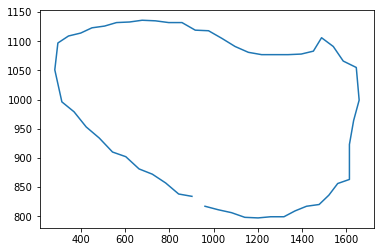

In [24]:
plt.plot(cont[:, 0], cont[:, 1])

In [13]:
from scipy.interpolate import UnivariateSpline

ImportError: cannot import name decomp

In [14]:
import sys, scipy, numpy; print(scipy.__version__, numpy.__version__, sys.version_info)

('1.1.0', '1.14.5', sys.version_info(major=2, minor=7, micro=15, releaselevel='final', serial=0))


In [3]:
def computeHingePointNewTracker(xhead, yhead, xtail, ytail, xspine, yspine):
    m = (yhead-ytail)/(xhead-xtail);
    n = (0.5)*((yhead+ytail)-np.multiply(m, (xhead+xtail)));
    sz = np.shape(xspine)[0]
    m2 = np.matlib.repmat(m.copy(), 1, sz);
    n2 = np.matlib.repmat(n.copy(), 1, sz);
    distances = np.abs(np.multiply(m, xspine) - yspine + n)/np.sqrt(np.square(m)+1);

    return np.argmax(distances)

for frame_num in spline:
    xhead, yhead = meta_data.loc[frame_num, ['Head_x', 'Head_y']].values
    xtail, ytail = meta_data.loc[frame_num, ['Tail_x', 'Tail_y']].values
    xspine, yspine = spline[frame_num]
    inflec_index = computeHingePointNewTracker(xhead, yhead, xtail, ytail, xspine, yspine)